In [4]:
%load_ext autoreload
%autoreload 2
%pylab inline
# %matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


## 0. Import module

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import copy
#import math
import torch
import os
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image
#import numpy
#from numpy import linalg as LA
#import PIL
import seaborn as sns
sns.set(color_codes=True)

import sys
sys.path.append("../src/")
import model
import dataset
import config
#from utils.function import init_logging, init_environment, preprocess_image,\
#         recreate_image, get_lr, save_image
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map_for_comparision

## 1.Hyperparameter

In [6]:
resume = "011-161"
model_dir = "../saved/models"
generated_dir = "../saved/generated/"
backbone = "vgg16"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2.Load modal from dict

In [7]:
# model
net = model.Network(backbone=backbone, num_classes=101)
net.to(device)

# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt) 

Resume from model from exp: 011 at epoch 161


<All keys matched successfully>

In [8]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 3.1 Load Original Data 

In [9]:
# Load data
mean = [0.5495916, 0.52337694, 0.49149787]                                                                                                                            
std = [0.3202951, 0.31704363, 0.32729807]                                                                                                                             
reverse_mean = [-0.5495916, -0.52337694, -0.49149787]                                                                                                                    
reverse_std = [1/0.3202951, 1/0.31704363, 1/0.32729807]
train_transform = None
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    # transforms.RandomCrop(input_size),                                                                                                                              
    # transforms.RandomHorizontalFlip(),                                                                                                                              
    # transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),                                                                                                
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = dataset.Caltech101(root="../data/", is_train=True, transform=train_transform)

trainset.set_data([100], 30)
#image, label, imgs_path = trainset
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


## 3.2 Load optimized data from given path

In [10]:
save_dir = "../saved/generated/"
################### Hyper-Parameter #######################
exp = "656"
epoch = "49900"
##########################################################
ab_path = os.path.join(save_dir, exp, epoch)

In [11]:
# Load image
optimized_data, valid_imgs_path, valid_imgs_index = load_imgs(ab_path, imgs_path, non_exists_ok=True)
valid_imgs, valid_labels = extract_valid(images, labels, valid_imgs_index)
optimized_data = zscore(optimized_data, mean, std)

Load from ../saved/generated/656/49900/image_0001.jpg
Load from ../saved/generated/656/49900/image_0004.jpg
Load from ../saved/generated/656/49900/image_0005.jpg
Load from ../saved/generated/656/49900/image_0006.jpg
Load from ../saved/generated/656/49900/image_0007.jpg
Load from ../saved/generated/656/49900/image_0010.jpg
Load from ../saved/generated/656/49900/image_0014.jpg
Load from ../saved/generated/656/49900/image_0015.jpg
Load from ../saved/generated/656/49900/image_0016.jpg
Load from ../saved/generated/656/49900/image_0017.jpg
Load from ../saved/generated/656/49900/image_0018.jpg
Load from ../saved/generated/656/49900/image_0019.jpg
Load from ../saved/generated/656/49900/image_0021.jpg
Load from ../saved/generated/656/49900/image_0022.jpg
Load from ../saved/generated/656/49900/image_0025.jpg
Load from ../saved/generated/656/49900/image_0026.jpg
Load from ../saved/generated/656/49900/image_0030.jpg
Load from ../saved/generated/656/49900/image_0035.jpg
Load from ../saved/generated

In [12]:
index2image = {index: item.split("/")[-1].split(".")[0] for index, item in enumerate(valid_imgs_path)}
index2image

{0: 'image_0001',
 1: 'image_0004',
 2: 'image_0005',
 3: 'image_0006',
 4: 'image_0007',
 5: 'image_0010',
 6: 'image_0014',
 7: 'image_0015',
 8: 'image_0016',
 9: 'image_0017',
 10: 'image_0018',
 11: 'image_0019',
 12: 'image_0021',
 13: 'image_0022',
 14: 'image_0025',
 15: 'image_0026',
 16: 'image_0030',
 17: 'image_0035',
 18: 'image_0036',
 19: 'image_0038',
 20: 'image_0039',
 21: 'image_0041',
 22: 'image_0043',
 23: 'image_0044',
 24: 'image_0045',
 25: 'image_0047',
 26: 'image_0048',
 27: 'image_0053',
 28: 'image_0055',
 29: 'image_0059'}

In [13]:
save_dict = {
    "save_dir": "../saved/generated/"+ exp + "/feature_map/",
    "index2image": index2image, 
    "save_name": "layer-{}-{}.pdf"
}

try: 
    os.mkdir(save_dict["save_dir"])
except FileExistsError:
    print("Directory has been created {}".format(save_dict["save_dir"]))

Directory has been created ../saved/generated/656/feature_map/


In [14]:
# Move to device
opt_image = torch.from_numpy(optimized_data).to(device)
original_image = torch.cat(valid_imgs, dim=0).to(device)

## 4. Obtain feature from conv layers.

In [15]:
# hyper parameter
conv_output_indexes = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]
conv_output_indexes_dict = dict(zip(conv_output_indexes, range(len(conv_output_indexes))))
print(conv_output_indexes_dict)

{1: 0, 3: 1, 6: 2, 8: 3, 11: 4, 13: 5, 15: 6, 18: 7, 20: 8, 22: 9, 25: 10, 27: 11, 29: 12}


In [16]:
conv_output, layer_max_min = obtain_features_map(original_image, net.model.features, layer_output_indexes=conv_output_indexes)
opt_feature_map, opt_layer_max_min = obtain_features_map(opt_image, net.model.features, layer_output_indexes=conv_output_indexes)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 64, 224, 224])
1 ReLU(inplace=True) torch.Size([30, 64, 224, 224])
Index:1, ReLU(inplace=True)
0.0 15.452186
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 64, 224, 224])
3 ReLU(inplace=True) torch.Size([30, 64, 224, 224])
Index:3, ReLU(inplace=True)
0.0 27.429113
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([30, 64, 112, 112])
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 128, 112, 112])
6 ReLU(inplace=True) torch.Size([30, 128, 112, 112])
Index:6, ReLU(inplace=True)
0.0 33.276093
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 128, 112, 112])
8 ReLU(inplace=True) torch.Size([30, 128, 112, 112])
Index:8, ReLU(inplace=True)
0.0 55.65539
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([30, 128, 56, 56])
10 Conv2

## !! 5. Visualization Here.

In [ ]:
visualize_features_map_for_comparision(img_index=0, layer_index=1, features_map=conv_output, 
                                       opt_feature_map=opt_feature_map, cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, 
                                       plt_mode="real", top_k=10, layer_max_min=None, color_map="gray")

In [ ]:
visualize_features_map_for_comparision(img_index=0, layer_index=1, features_map=conv_output, 
                                       opt_feature_map=opt_feature_map, cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, 
                                       plt_mode="real", top_k=10, layer_max_min=None, color_map="jet")

In [22]:
visualize_features_map_for_comparision(img_index=0, layer_index=6, features_map=conv_output, 
                                       opt_feature_map=opt_feature_map, cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, save_dict=save_dict, 
                                       plt_mode="real", top_k=10, layer_max_min=None, color_map="gray")

Plot mode is => real
Successfully Save pdf to ../saved/generated/656/feature_map/layer-6-image_0001.pdf


Plot mode is => img_scale
Color map is => jet


IndexError: GridSpec slice would result in no space allocated for subplot

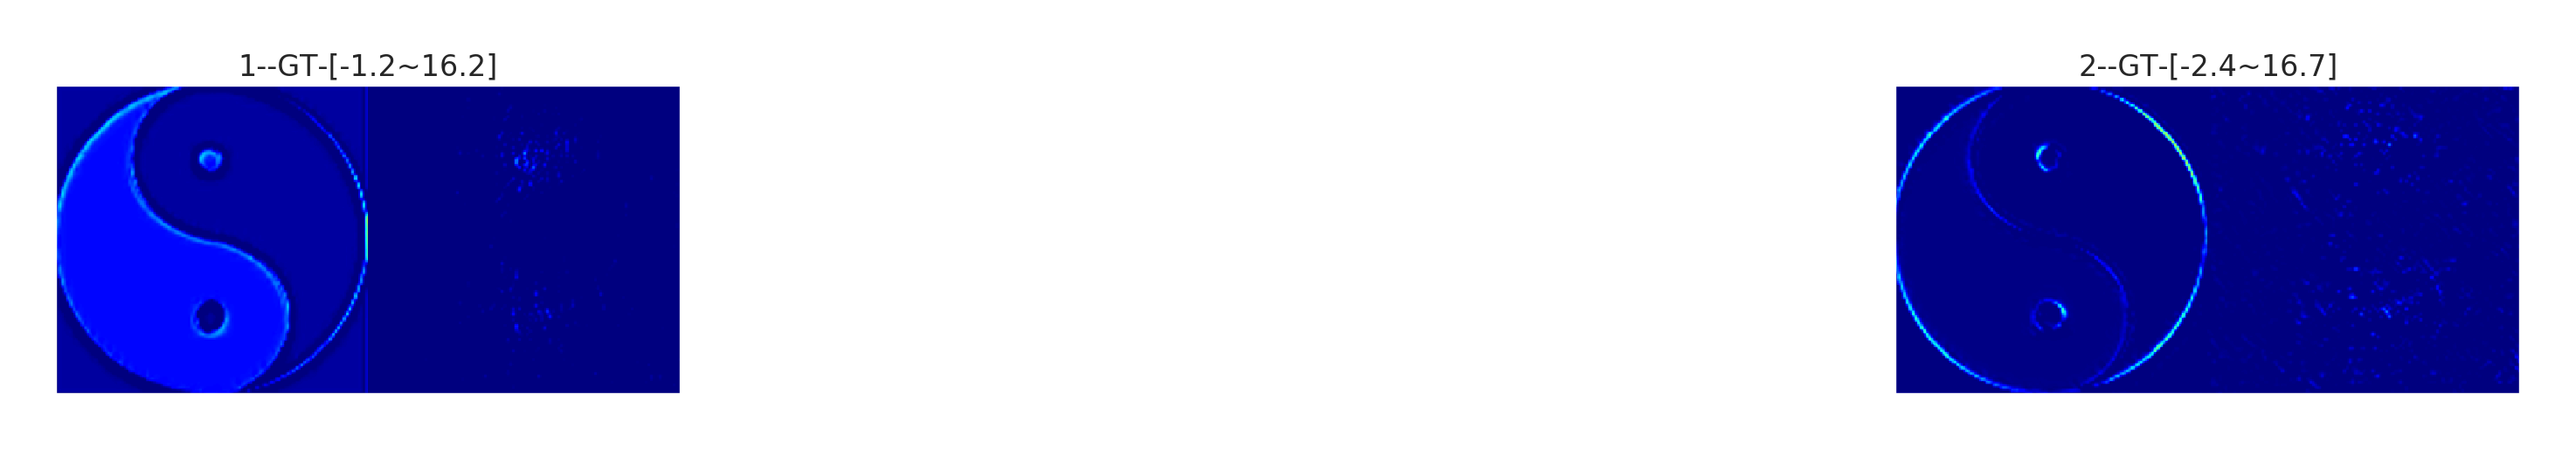

In [26]:
visualize_features_map_for_comparision(img_index=0, layer_index=6, features_map=conv_output, 
                                       opt_feature_map=opt_feature_map, 
                                       cols=4, conv_output_index_dict=conv_output_indexes_dict, 
                                       save_dict=save_dict, plt_mode="img_scale", top_k=10, 
                                       layer_max_min=None, color_map="jet")

In [ ]:
visualize_features_map_for_comparision(img_index=0, layer_index=25, features_map=conv_output, 
                                       opt_feature_map=opt_feature_map, cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, 
                                       save_dict=save_dict, plt_mode="img_scale", top_k=10, 
                                       layer_max_min=None, color_map="gray")

In [23]:
visualize_features_map_for_comparision(img_index=0, layer_index=25, features_map=conv_output, 
                                       opt_feature_map=opt_feature_map, cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, 
                                       save_dict=save_dict, plt_mode="img_scale", top_k=10, 
                                       layer_max_min=None, color_map="jet")

Plot mode is => img_scale


ValueError: Image size of 5400x69000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3600x2400 with 0 Axes>

ValueError: Image size of 5400x69000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 5400x69000 with 512 Axes>